In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from utils import *

In [2]:
path="/Users/Abdoul_Aziz_Berrada/Documents/M2_MOSEF/2_Projets/Semestre1/CreditScoring/"
train = pd.read_csv(path+"train.csv")
train = train.drop("Unnamed: 0", axis = 1)
test = pd.read_csv(path+"test.csv")
test = test.drop("Unnamed: 0", axis = 1)
data = pd.read_csv(path+"data_clean.csv")
data = data.drop("Unnamed: 0", axis = 1)

In [3]:
classes = sc.woebin(data, y="BAD", positive=1, method="chimerge")

[INFO] creating woe binning ...
Binning on 5960 rows and 13 columns in 00:00:16


In [4]:
train_woe = sc.woebin_ply(train, classes)
test_woe = sc.woebin_ply(test, classes)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [5]:
y_train = train_woe["BAD"]
X_train = train_woe.drop(["BAD",'REASON_woe' ], axis =1)

y_test = test_woe["BAD"]
X_test = test_woe.drop(["BAD", 'REASON_woe'], axis =1)

In [6]:
print("Les features sélectionnées sont:")
print(X_train.columns)
print("Elles sont au nombre de", X_train.shape[1])

Les features sélectionnées sont:
Index(['MORTDUE_woe', 'DELINQ_woe', 'NINQ_woe', 'CLAGE_woe', 'CLNO_woe',
       'DEBTINC_woe', 'YOJ_woe', 'DEROG_woe', 'VALUE_woe', 'LOAN_woe',
       'JOB_woe'],
      dtype='object')
Elles sont au nombre de 11


In [7]:
grid_search("RandomForestClassifier", X_train, y_train )

RandomForestClassifier
------
L'opération a pris 52.68s
Les meilleurs paramètres sont: {'max_depth': 50, 'max_features': 3, 'n_estimators': 25}
Le meilleur score AUC est: 0.92


In [8]:
grid_search("DecisionTreeClassifier", X_train, y_train )

DecisionTreeClassifier
------
L'opération a pris 7.04s
Les meilleurs paramètres sont: {'max_depth': 6, 'max_features': 7}
Le meilleur score AUC est: 0.86


In [9]:
grid_search("LinearDiscriminantAnalysis", X_train, y_train )

LinearDiscriminantAnalysis
------
L'opération a pris 0.26s
Les meilleurs paramètres sont: {}
Le meilleur score AUC est: 0.88


In [10]:
grid_search("GradientBoostingClassifier", X_train, y_train )

GradientBoostingClassifier
------
L'opération a pris 10.43s
Les meilleurs paramètres sont: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 25}
Le meilleur score AUC est: 0.90


In [11]:
grid_search("KNeighborsClassifier", X_train, y_train )

KNeighborsClassifier
------
L'opération a pris 2.60s
Les meilleurs paramètres sont: {'n_neighbors': 35}
Le meilleur score AUC est: 0.87


In [12]:
def model_comp(model, X_train = X_train, y_train = y_train, 
          X_test = X_test, y_test = y_test, 
          smote = True, show_roc = True, show_conf_matrix = False, cut_off = 0.45, show_prc = False) : 
    
    b = re.findall(r"[A-Za-z0-9]+", str(model))
    if smote == True:
        print("SMOTE")
        print("--------")
        from imblearn.over_sampling import SMOTE
        smote = SMOTE(random_state=42 , k_neighbors=15)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        
    lr = model.fit(X_train, y_train)
    print("train score %.2f" %lr.score(X_train, y_train))
    print("--------")
    
        #PREDICTION DES Y_PRED
    train_pred = lr.predict_proba(X_train)[:,1]
    test_pred = lr.predict_proba(X_test)[:,1]
    print("test score %.2f" %lr.score(X_test, y_test))
    
    print("--------")
    print("Cut-off : ", cut_off)
    
        #ACCURACY, PRECISION ET TOUTE LA CLIQUE AU SEUIL DE 50% DE CONFIANCE (STANDARD)
    print("--------")
    print("classification_report\n")
    test_pred_b = (test_pred > cut_off).astype(bool)
    train_pred_b = (train_pred > cut_off).astype(bool)
    print(classification_report(y_test, test_pred_b))
    print("\n")

    train_pred_b = (train_pred > cut_off).astype(bool)
    
            #MATRICE DE CONFUSION
    if show_conf_matrix == True : 
        print("Matrice de confusion\n")
        print(confusion_matrix(y_test, test_pred_b))
        print("--------")
        #AUC
    fpr, tpr, _= roc_curve(y_test, test_pred)
    roc_auc = auc(fpr, tpr)
    fpr_, tpr_, _train= roc_curve(y_train, train_pred)
    roc_auc_ = auc(fpr_, tpr_)
    print("L'AUC est de %.2f" %roc_auc)
    print("--------")
    Gini = roc_auc * 2 - 1
    print('Gini: %.2f' % (Gini))
    print("--------")
    
    if show_roc == True:
        print('roc curve')
        
        plt.figure(figsize=(6,6))
        plt.xlim([-0.01, 1.00])
        plt.ylim([-0.01, 1.01])
        plt.plot(fpr, tpr, lw=3, label='roc curve - Test (auc = {:0.2f})'.format(roc_auc))
        #plt.plot(fpr_, tpr_, lw=3, label='roc curve - Train (auc = {:0.2f})'.format(roc_auc_))
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title(b[0], fontsize=16)
        plt.legend(loc='lower right', fontsize=13)
        plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
        plt.axes().set_aspect('equal')
        plt.show()
        print("\n")
        
       
    precision, recall, thresholds = precision_recall_curve(y_test, test_pred)
    precision_, recall_, thresholds_ = precision_recall_curve(y_train, train_pred)
    
    closest_zero = np.argmin(np.abs(thresholds))
    closest_zero_p = precision[closest_zero]
    closest_zero_r = recall[closest_zero]
    
    closest_zero_ = np.argmin(np.abs(thresholds_))
    closest_zero_p_ = precision_[closest_zero_]
    closest_zero_r_ = recall_[closest_zero_]
    
    if show_prc == True : 
        
        print("precision_recall_curve")
        plt.figure(figsize = (6,6))
        plt.xlim([0.0, 1.01])
        plt.ylim([0.0, 1.01])
        plt.plot(precision, recall, label='prc - Test')
        #plt.plot(precision_, recall_, label='prc - Train')
        #plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
        #plt.plot(closest_zero_p_, closest_zero_r_, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
        plt.xlabel('Precision', fontsize=16)
        plt.ylabel('Recall', fontsize=16)
        plt.axes().set_aspect('equal')
        plt.legend(loc='lower left', fontsize=13)
        plt.show()

    J = tpr - fpr
    ix = np.argmax(J)
    seuil_opt = thresholds[ix]
    
    J_ = tpr_ - fpr_
    ix_ = np.argmax(J_)
    seuil_opt_ = thresholds_[ix_]
    print('Meilleur cut-off test : %f' % (seuil_opt))
    print('Meilleur cut-off train : %f' % (seuil_opt_))
    
    return fpr, tpr, roc_auc

SMOTE
--------
train score 0.81
--------
test score 0.80
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.93      0.77      0.84       927
           1       0.50      0.80      0.61       265

    accuracy                           0.78      1192
   macro avg       0.71      0.78      0.73      1192
weighted avg       0.83      0.78      0.79      1192



L'AUC est de 0.88
--------
Gini: 0.75
--------
roc curve


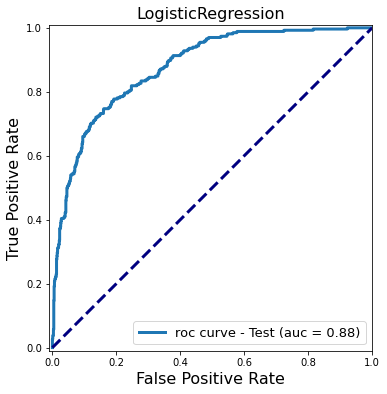



Meilleur cut-off test : 0.086545
Meilleur cut-off train : 0.113719


In [13]:
fpr, tpr, roc_auc = model_comp(model = LogisticRegression(penalty='l2', C=15, max_iter= 100, random_state=42))

SMOTE
--------
train score 1.00
--------
test score 0.85
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.86      0.98      0.91       927
           1       0.84      0.42      0.56       265

    accuracy                           0.85      1192
   macro avg       0.85      0.70      0.74      1192
weighted avg       0.85      0.85      0.83      1192



L'AUC est de 0.92
--------
Gini: 0.83
--------
roc curve


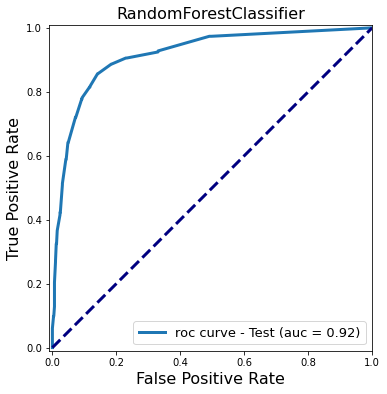



Meilleur cut-off test : 0.480000
Meilleur cut-off train : 0.720000


In [14]:
fpr_r, tpr_r, roc_auc_r = model_comp(model = RandomForestClassifier(max_depth=75, max_features=3, n_estimators = 25, random_state=42))

SMOTE
--------
train score 0.85
--------
test score 0.78
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.81      0.94      0.87       927
           1       0.51      0.21      0.29       265

    accuracy                           0.78      1192
   macro avg       0.66      0.58      0.58      1192
weighted avg       0.74      0.78      0.74      1192



L'AUC est de 0.76
--------
Gini: 0.53
--------
roc curve


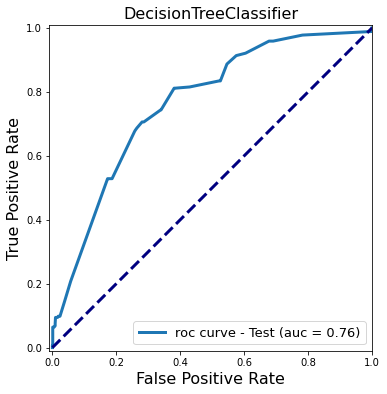



Meilleur cut-off test : 0.514286
Meilleur cut-off train : 0.398406


In [15]:
fpr_d, tpr_d, roc_auc_d= model_comp(model = DecisionTreeClassifier(max_depth=6, max_features=6))

SMOTE
--------
train score 0.93
--------
test score 0.83
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.85      0.95      0.90       927
           1       0.71      0.39      0.50       265

    accuracy                           0.83      1192
   macro avg       0.78      0.67      0.70      1192
weighted avg       0.82      0.83      0.81      1192



L'AUC est de 0.87
--------
Gini: 0.74
--------
roc curve


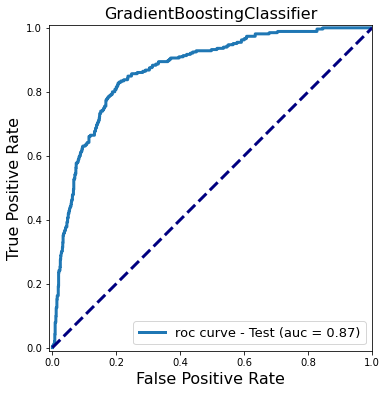



Meilleur cut-off test : 0.065066
Meilleur cut-off train : 0.069399


In [16]:
fpr_gb, tpr_gb, roc_auc_gb = model_comp(model = GradientBoostingClassifier(learning_rate=0.2, max_depth=5, n_estimators=25, random_state=2))

SMOTE
--------
train score 0.80
--------
test score 0.81
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.93      0.78      0.85       927
           1       0.51      0.79      0.62       265

    accuracy                           0.78      1192
   macro avg       0.72      0.79      0.73      1192
weighted avg       0.84      0.78      0.80      1192



L'AUC est de 0.88
--------
Gini: 0.75
--------
roc curve


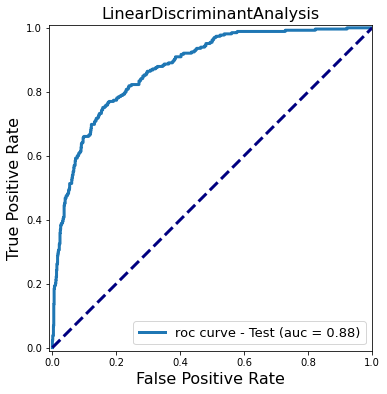



Meilleur cut-off test : 0.063782
Meilleur cut-off train : 0.086092


In [17]:
fpr_lda, tpr_lda, roc_auc_lda = model_comp(model = LinearDiscriminantAnalysis())

SMOTE
--------
train score 0.84
--------
test score 0.77
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.94      0.72      0.81       927
           1       0.46      0.84      0.59       265

    accuracy                           0.74      1192
   macro avg       0.70      0.78      0.70      1192
weighted avg       0.83      0.74      0.76      1192



L'AUC est de 0.87
--------
Gini: 0.74
--------
roc curve


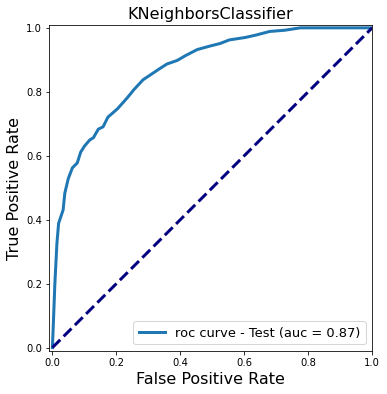



Meilleur cut-off test : 0.628571
Meilleur cut-off train : 0.542857


In [18]:
fpr_knn, tpr_knn, roc_auc_knn = model_comp(model = KNeighborsClassifier(n_neighbors=35))

SMOTE
--------
train score 0.93
--------
test score 0.86
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       927
           1       0.65      0.70      0.68       265

    accuracy                           0.85      1192
   macro avg       0.78      0.80      0.79      1192
weighted avg       0.85      0.85      0.85      1192



L'AUC est de 0.89
--------
Gini: 0.79
--------
roc curve


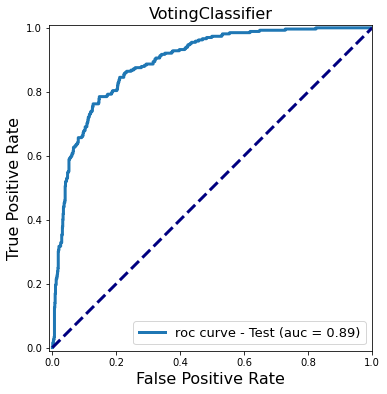



Meilleur cut-off test : 0.084767
Meilleur cut-off train : 0.130275


In [19]:

clf1 = KNeighborsClassifier(n_neighbors=35)
clf2 = RandomForestClassifier(max_depth=75, max_features=3, n_estimators = 25, random_state=42)
clf3 = LogisticRegression(penalty='l2', C=15, max_iter= 100, random_state=42)
clf4 = LinearDiscriminantAnalysis()
clf5 = DecisionTreeClassifier(max_depth=8, max_features=9)
clf6 = GradientBoostingClassifier(learning_rate=0.2, max_depth=5, n_estimators=25, random_state=2)



estimators=[('knn', clf1), ('rf', clf2), ('lr', clf3), ('lda', clf4), ('dt', clf5), ('gb', clf6)]
vclf = VotingClassifier(estimators, voting='soft')
fpr_vc, tpr_vc, roc_auc_vc = model_comp(model = vclf)

SMOTE
--------
train score 1.00
--------
test score 0.86
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       927
           1       0.83      0.50      0.62       265

    accuracy                           0.87      1192
   macro avg       0.85      0.73      0.77      1192
weighted avg       0.86      0.87      0.85      1192



L'AUC est de 0.92
--------
Gini: 0.83
--------
roc curve


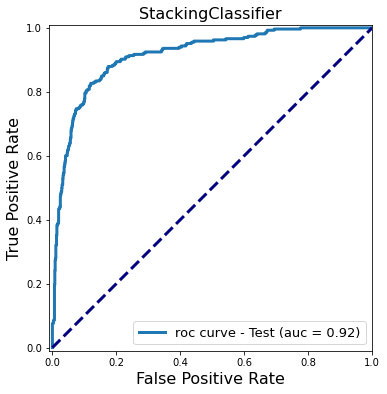



Meilleur cut-off test : 0.024182
Meilleur cut-off train : 0.094731


In [20]:
sclf = StackingClassifier(estimators)
fpr_sc, tpr_sc, roc_auc_sc = model_comp(model = sclf)

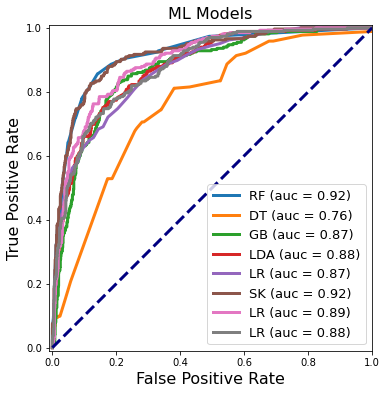

In [22]:
plt.figure(figsize=(6,6))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_r, tpr_r, lw=3, label='RF (auc = {:0.2f})'.format(roc_auc_r))
plt.plot(fpr_d, tpr_d, lw=3, label='DT (auc = {:0.2f})'.format(roc_auc_d))
plt.plot(fpr_gb, tpr_gb, lw=3, label='GB (auc = {:0.2f})'.format(roc_auc_gb))
plt.plot(fpr_lda, tpr_lda, lw=3, label='LDA (auc = {:0.2f})'.format(roc_auc_lda))
plt.plot(fpr_knn, tpr_knn, lw=3, label='LR (auc = {:0.2f})'.format(roc_auc_knn))

plt.plot(fpr_sc, tpr_sc, lw=3, label='SK (auc = {:0.2f})'.format(roc_auc_sc))
plt.plot(fpr_vc, tpr_vc, lw=3, label='LR (auc = {:0.2f})'.format(roc_auc_vc))
plt.plot(fpr, tpr, lw=3, label='LR (auc = {:0.2f})'.format(roc_auc))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ML Models', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()